In [139]:
from numpy import eye, linalg, arange, sqrt, diag, sin, pi, linspace, heaviside, sum as npsum, multiply, conjugate, real, array, zeros, copy
import matplotlib.pyplot as plt

In [140]:
# funcaozinha para inserir o range do eixo x, autovalores, autovetores e o numero de energias desejado na visualização; possivel inserir potencial para plotar junto
def plotEnPsi_finite_diff(x_values, en, psi, n, scale, potential):
    plt.plot(x_values, potential, c="C1140")
    for j in range(n):
        plt.hlines(
            en[j],
            xmin=x_values[0],
            xmax=x_values[-1],
            colors="C" + str(j),
            linestyles="--",
        )
        plt.plot(x_values, en[j] + scale * psi[:, j],  c="C" + str(j))
        y_min, y_max = (0.0, scale)
        plt.ylim(y_min, y_max)
    plt.show()

In [141]:
# PARAMETROS DO SISTEMA
h_bar=1 #planck reduzida
m = 0.067 #massa efetiva para GaAs na eq. de Schrödinger
L = 800  # tamanho do sistema
Ry = 26 #eV é a unidade de Energia
a0 = 0.05 #nm é a unidade de distância
h_bar2_m0 = Ry * a0**2
e2 = Ry * a0
k = 13 #constante dielétrica na eq. de Poisson
n2D = 5*10**(-5) #a.u. densidade experimentais

# parametros do poco (GaAs)
xmin_poco = 0.25 * L #a.u. parede do poço
xmax_poco = 0.75 * L #a.u. parede do poço
V_0_poco = 0.01 #a.u. profundidade do poço quadrado

# parametros do tempero
f = 0.05

# parâmetros de convergência
epsilon = 0.002 

# dopagem (0 representa o fundo do poço)
mu = 0.1

# DISCRETIZAÇÃO E INTERVALO ABSCISSAS
N=200 #Numero de pontos na rede
dx = L/(N+1)  # discretização> dx = L/N+1 => N = (L/dx) - 1
x = arange(0, N)*dx

# parametros iniciais no ciclo de autoconsistência
V_h_inicial = zeros(N)
n_3d_loop = zeros(N)

In [142]:
# LAPLACIANO 1D DISCRETIZADO
laplaciano = lambda dx,N: -(1 / (dx ** 2)) * (2 * eye(N) - eye(N, k=-1) - eye(N, k=1))
energia_cinetica = lambda m: -(0.5/m)*laplaciano(dx,N)

In [143]:
# DEFINIÇÃO DO POTENCIAL ESTRUTURAL
poco_quadrado_finito = (
    lambda profundidade, xmin, xmax, x: -profundidade
    * heaviside(  # somar profundidade apenas para deixar o fundo do poço = 0
        x - xmin, 1
    )
    * heaviside(xmax - x, 1)
    + profundidade
)   

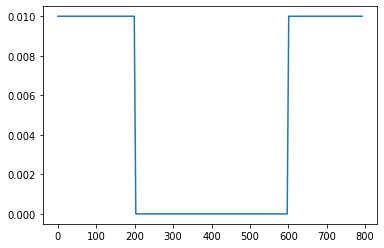

In [144]:
# POTENCIAIS
# scale = 2
V_poco_quadrado_finito = poco_quadrado_finito(
    profundidade=V_0_poco, xmin=xmin_poco, xmax=xmax_poco, x=x
)
V_hartree = lambda n_3d, k, dx, N: linalg.solve(laplaciano(dx, N), (-4*pi/k)*n_3d)
V_hartree_temperado = lambda tempero, V_1, V_3: f*V_1 + (1-f)*V_3
V_total = lambda V_estrutural, V_interacao: V_estrutural + V_interacao 
plt.plot(x, V_poco_quadrado_finito)
plt.show()


In [145]:
# E0_mu (soma de níveis ocupados)
E0_mu = lambda mu, E0_list: npsum(E0_list, where=E0_list<mu)
# Numero de níveis ocupados 
N_levels = lambda mu, E0_list: npsum(E0_list<mu)
# D.O.L 3D
def n_3d(phi_list, E0_list, mu, m): 
  vectors = array([(m*(mu-E0_list[j])/(2*pi*h_bar**2))*(conjugate(phi_list[j])*phi_list[j]) for j in range(N_levels(mu, E0_list))])
  if N_levels(mu, E0_list) > 1:
    return npsum(vectors, axis=0)
  return vectors
# D.O.L 2D
n_2d_params = lambda mu, m, E0_list: [npsum(E0_list<mu)*m/(2*pi*h_bar**2),-E0_mu(mu, E0_list)] #retorna os coeficientes linear e angular, n_2d_params[0]==a e n_2d_params[1]==b

In [146]:
# O HAMILTONIANO
H = lambda V_efetivo, m: energia_cinetica(m) + diag(
    V_efetivo
)

In [147]:
# Primeira vez que foi executado o programa:
V_1 = V_total(V_poco_quadrado_finito, V_hartree_temperado(1, V_h_inicial, V_hartree(n_3d_loop, k, dx, N)))
# acrescentando o potencial "infinito" nas bordas
V_1[0] = 1000
V_1[-1] = 1000
# diagonalização
E0_list, phi_list = linalg.eigh(H(V_1,m))
N_ocupados = N_levels(mu, E0_list)
print("Numero de niveis ocupados antes do loop", N_ocupados)
print("Energias ocupadas antes do loop", E0_list[:N_ocupados])

# teste de consistência para ver as energias do poço
# plotEnPsi_finite_diff(x, E0_list, phi_list, 3, 0.02, V_1)

n_3d_loop = n_3d(phi_list, E0_list, mu, m)
n_3d_loop = n_3d_loop if n_3d_loop.size != N else zeros(N)
n_2d_loop = n_2d_params(mu, m, E0_list)
print("formato n3d antes loop =>", n_3d_loop.shape)
# obtendo energias e estados
# E0, phi_list = linalg.eigh(H)

# Loop:
convergiu = False
iteracao=1
while not convergiu:
  print("iter=", iteracao)
  V_novo = V_total(V_poco_quadrado_finito, V_hartree_temperado(f, V_1, V_hartree(n_3d_loop, k, dx, N)))
  # acrescentando o potencial "infinito" nas bordas
  V_novo[0] = 1000
  V_novo[-1] = 1000
  print('formato potencial', V_novo.shape)
  # diagonalização
  E0_list, phi_list = linalg.eigh(H(V_novo,m))
  N_ocupados = N_levels(mu, E0_list)
  print("Numero de niveis ocupados",N_ocupados )
  print("Energias ocupadas", E0_list[:N_ocupados])
  print("Soma energias ocupadas", E0_mu(mu, E0_list))
  n_3d_loop_novo = n_3d(phi_list, E0_list, mu, m)
  # print("n_3d_loop_novo", n_3d_loop_novo)
  print("size",n_3d_loop_novo.size)
  # n_3d_loop_novo = n_3d_loop_novo if n_3d_loop_novo.size != N else zeros(N)
  n_2d_loop_novo = n_2d_params(mu, m, E0_list)
  print("formato n3d no loop =>", n_3d_loop_novo.shape)
  
  # teste convergencia
  if (abs((n_2d_loop_novo[0] - n_2d_loop[0])/n_2d_loop[0])<epsilon) and (abs((n_2d_loop_novo[1] - n_2d_loop[1])/n_2d_loop[1])<epsilon):
    # se convergiu
    print("convergiu!")
    convergiu=True
  else:
    # se nao convergiu
    V_1 = copy(V_novo)
    print("formato V_1 novo", V_1.shape)
    n_2d_loop = copy(n_2d_loop_novo)
    n_3d_loop = copy(n_3d_loop_novo)
    iteracao+=1
    

Numero de niveis ocupados antes do loop 28
Energias ocupadas antes do loop [0.00035871 0.00142797 0.00318384 0.00556987 0.00842723 0.01095237
 0.01185515 0.01296115 0.01538913 0.01730513 0.01930794 0.02226007
 0.02526152 0.02804345 0.03136124 0.03521955 0.03897006 0.04278447
 0.04713503 0.05180858 0.05642394 0.06122447 0.06649179 0.07198785
 0.07749006 0.08322261 0.08935461 0.09567498]
formato n3d antes loop => (200,)
iter= 1
formato potencial (200,)
Numero de niveis ocupados 28
Energias ocupadas [0.00036083 0.00143686 0.00320565 0.00561536 0.00852656 0.01126186
 0.01228877 0.01326069 0.01567587 0.0176573  0.0195941  0.02251259
 0.0255642  0.02833637 0.03161164 0.03548367 0.03925574 0.04305054
 0.04738335 0.05207369 0.05669616 0.06148045 0.06674146 0.07225058
 0.07775394 0.08347475 0.0896053  0.09593489]
Soma energias ocupadas 1.0380931567124179
size 200
formato n3d no loop => (200,)
formato V_1 novo (200,)
iter= 2
formato potencial (200,)
Numero de niveis ocupados 0
Energias ocupadas 

ValueError: solve1: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (m,m),(m)->(m) (size 0 is different from 200)

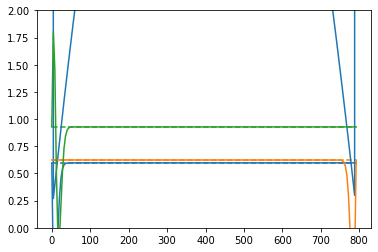

In [149]:
plotEnPsi_finite_diff(x, E0_list, phi_list, 3, 10, V_novo)

In [ ]:
plt.plot(x, V_novo)
plt.ylim(0.005,0.018)
plt.show()